In [1]:
import os
import sys
import glob
import pickle
import tables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from comet_ml.api import API, APIExperiment
from comet_ml.query import Tag

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

#### Find the best experiment given a set of tags

In [2]:
api = API(api_key = os.environ['COMET_API_KEY'])
workspace = 'danielelinaro'
project_name = 'inertia'
area_IDs = [1, 2]
D = 2
DZA = 60
query = Tag('two-area') & \
        Tag('_'.join([f'area{area_id}' for area_id in area_IDs])) & \
        Tag(f'D={D}') & \
        Tag(f'DZA={DZA}') & \
        Tag('1D_pipeline')
experiments = api.query(workspace, project_name, query, archived=False)
experiment_IDs = []
MAPE = []
val_loss = []
tags =  []
for experiment in experiments:
    ID = experiment.id
    experiment_IDs.append(ID)
    sys.stdout.write(f'Downloading data for experiment ID {ID}... ')
    metrics = experiment.get_metrics()
    sys.stdout.write('done.\n')
    val_loss.append(np.array([float(m['metricValue']) for m in metrics if m['metricName'] == 'val_loss']))
    has_MAPE = False
    for m in metrics:
        if m['metricName'] == 'mape_prediction':
            val = m['metricValue']
            try:
                MAPE.append(float(val))
            except:
                MAPE.append(list(map(float, val[1:-1].split(' ')[:2])))
            has_MAPE = True
            break
    tags.append(experiment.get_tags())
    print(f'  val_loss: {val_loss[-1].min():.4f}')
    if has_MAPE:
        print(f'      MAPE: {MAPE[-1]}%')
    else:
        print('      MAPE: [experiment not terminated]')
    print('      Tags: "{}"'.format('" "'.join(tags[-1])))
# idx = np.argmin(MAPE)
idx = np.argmin([loss.min() for loss in val_loss])
experiment_ID = experiment_IDs[idx]
MAPE = MAPE[idx]
val_loss = val_loss[idx]
tags = tags[idx]
print(f'The best experiment is {experiment_ID[:6]} (val_loss = {val_loss.min():.4f}, MAPE = {MAPE}%).')

  val_loss: 0.0305
      MAPE: [0.39884144, 0.5710586]%
      Tags: "1D_pipeline" "area1_area2" "D=2" "DZA=60" "neural_network" "ReLU_none" "two-area"
  val_loss: 0.0342
      MAPE: [0.48145494, 0.74194443]%
      Tags: "1D_pipeline" "area1_area2" "cyclical_lr" "D=2" "DZA=60" "neural_network" "ReLU_none" "two-area"
The best experiment is 772041 (val_loss = 0.0305, MAPE = [0.39884144, 0.5710586]%).


In [3]:
experiments_path = '../experiments/neural_network/'
checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(experiments_path + experiment_ID \
                                      + '/parameters.pkl', 'rb'))
epochs = [int(os.path.split(file)[-1].split('.')[1].split('-')[0]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[epochs.index(np.argmin(val_loss) + 1)]
model = keras.models.load_model(best_checkpoint, compile=True)
try:
    data_dirs = ['../' + data_dir.format(area_id) for area_id in network_parameters['area_IDs'] \
                 for data_dir in network_parameters['data_dirs']]
except:
    data_dirs = ['../' + data_dir.format(gen_id) for gen_id in network_parameters['generator_IDs'] \
                 for data_dir in network_parameters['data_dirs']]
# we need mean and standard deviation of the training set to normalize the data
x_train_mean = network_parameters['x_train_mean']
x_train_std  = network_parameters['x_train_std']
if not os.path.isdir(data_dirs[0]):
    data_dirs[0] = '../data/var_H_G1/' + os.path.split(data_dirs[0])[-1]
print('Loaded network from {}.'.format(best_checkpoint))
print('Data directories are {}.'.format(data_dirs))

Loaded network from ../experiments/neural_network/7720412849ad4331a3d0391b5a639d70/checkpoints/weights.0925-0.030510.h5.
Data directories are ['../data/two-area/var_H_area_1/two-area_D=2_DZA=60.0', '../data/two-area/var_H_area_2/two-area_D=2_DZA=60.0'].


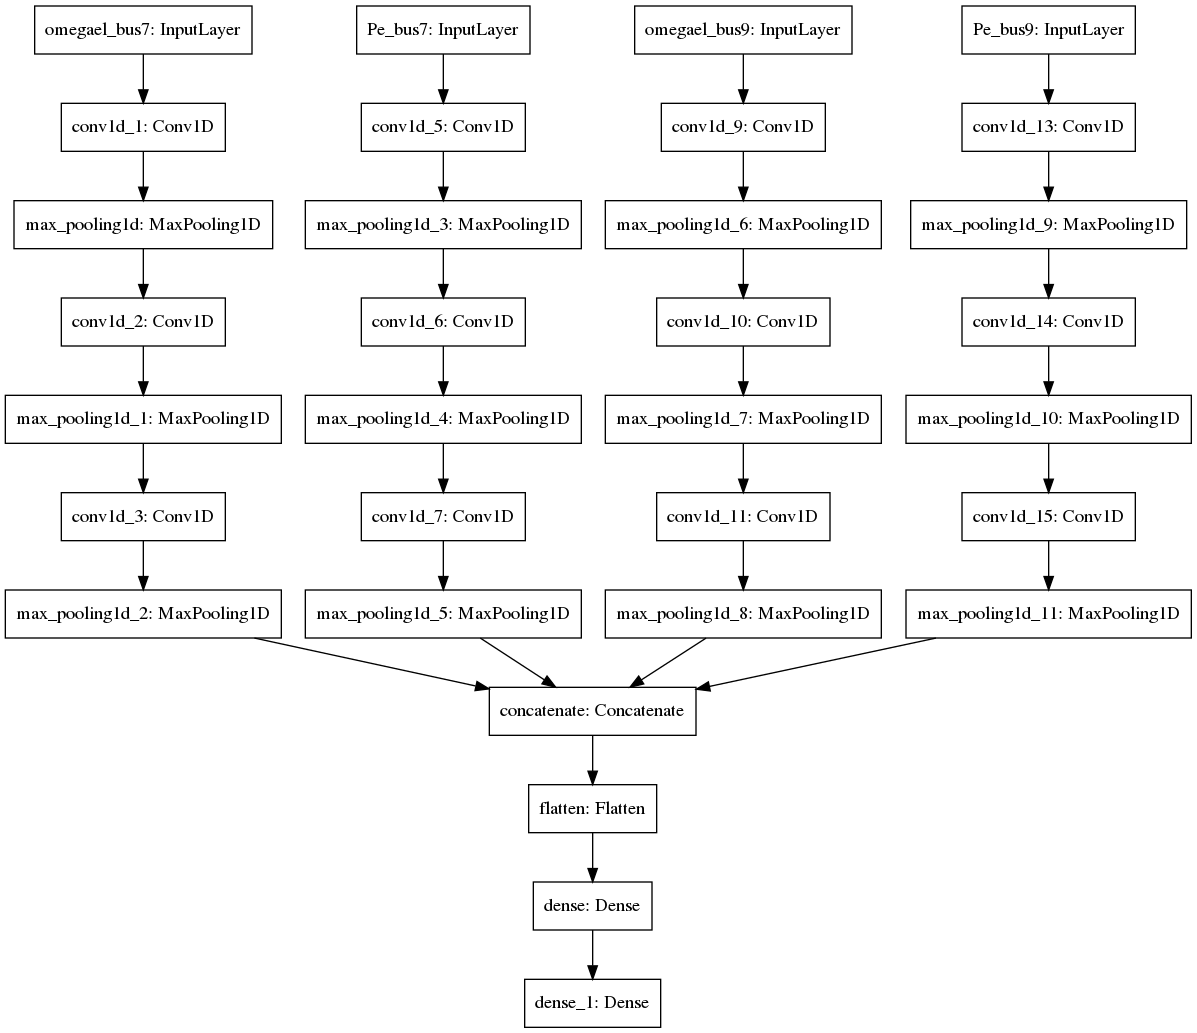

In [4]:
keras.utils.plot_model(model, show_shapes=False, dpi=96)

### Constant inertia
1. the value of inertia is either 3.5 or 8.5, for both areas
1. **omega** and **Pe** of both areas used for the estimation

In [5]:
default_H = [6.5, 6.175]
bus_IDs = [7, 9]

window_dur = 60
window_step = 10

H_values = [3.5, 8.5]
N_H = len(H_values)

data_normalized = [[] for _ in range(len(bus_IDs))]
inertia = [[] for _ in range(len(bus_IDs))]

var_names = [var_name.format(bus_ID) for bus_ID in bus_IDs for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

H = [0,0]
for i, bus_to_predict in enumerate(bus_IDs):
    other_bus = bus_IDs[1 - i]
    for j,h in enumerate(H_values):
        H[i] = h
        H[1-i] = default_H[1-i]
        data_file = data_dirs[0] + f'/inertia_{H[0]:.3f}_{H[0]:.3f}_{H[1]:.3f}_{H[1]:.3f}.h5'

        t, _, data_norm, data_sliding, _ = load_data_slide([data_file],
                                                            var_names,
                                                            data_mean,
                                                            data_std,
                                                            window_dur,
                                                            window_step,
                                                            verbose = True)
        data_normalized[i].append(data_norm)
        dt = np.diff(t[:2])[0]
        time, HH, _ = predict(model, data_sliding, window_step, dt)
        inertia[i].append(HH)

Window size: 600 samples
Number of trials: 3540
Window size: 600 samples
Number of trials: 3540
Window size: 600 samples
Number of trials: 3540
Window size: 600 samples
Number of trials: 3540


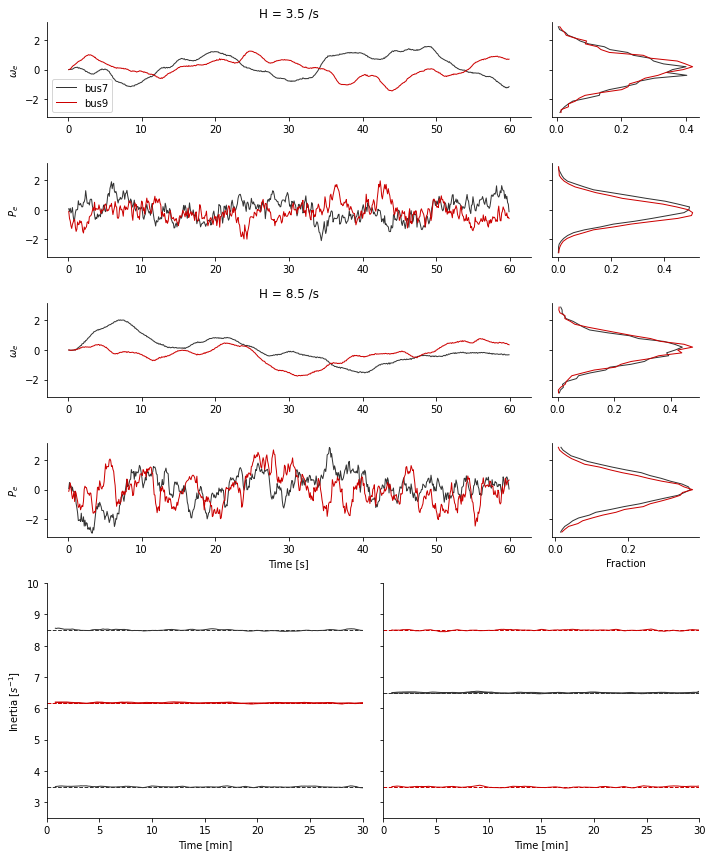

In [6]:
fig = plt.figure(figsize=(10, (N_H + 2) * 3))
gs = fig.add_gridspec(N_H * 2 + 2, 4)
ax = []
for i in range(0, len(H_values)*2, 2):
    ax.append([fig.add_subplot(gs[i, :3]), fig.add_subplot(gs[i, 3])]),
    ax.append([fig.add_subplot(gs[i+1, :3]), fig.add_subplot(gs[i+1, 3])]),
ax.append([fig.add_subplot(gs[-2:,:2]), fig.add_subplot(gs[-2:,2:])])

col = [[.2,.2,.2], [.8,0,0]]

idx = t < 60
var_names = 'omegael_bus{}','Pe_bus{}'
for i,bus_ID in enumerate(bus_IDs):
    for j,h in enumerate(H_values):
        ax[-1][i].plot(time[[0,-1]] / 60, h + np.zeros(2), '--', color=col[i], lw=1)
        ax[-1][i].plot(time[[0,-1]] / 60, default_H[1-i] + np.zeros(2), '--', color=col[1-i], lw=1)
        for k,var_name in enumerate(var_names):
            key = var_name.format(bus_ID)
            value = data_normalized[i][j][key]
            n,edges = np.histogram(value, bins=31, range=(-3,3), density=True)
            m = j * len(var_names) + k
            ax[m][0].plot(t[idx], value[idx], color=col[i], lw=1, label=key.split('_')[1])
            ax[m][1].plot(n, edges[:-1] + np.diff(edges[:2])[0] / 2, color=col[i], lw=1)
            ax[-1][i].plot(time / 60, inertia[i][j][:,k], color=col[k], lw=1)
        ax[j * 2][0].set_title(f'H = {h} /s')
    ax[-1][i].set_xlabel('Time [min]')
    
for a in ax:
    for side in 'right','top':
        for i in range(2):
            a[i].spines[side].set_visible(False)

ax[0][0].legend(loc='best')
for i in range(len(ax)):
    if i < len(ax) - 2:
        ax[i][0].get_shared_x_axes().join(ax[i][0], ax[i+1][0])
    ax[i][0].get_shared_y_axes().join(ax[i][0], ax[i][1])
    ax[i][1].set_yticklabels([])

for i in range(0, len(ax)-1, 2):
    ax[i][0].set_ylabel(r'$\omega_{e}$')
    ax[i+1][0].set_ylabel(r'$P_{e}$')
ax[-1][0].get_shared_x_axes().join(ax[-1][0], ax[-1][1])

ax[-1][0].set_xlim([0,30])
ax[-1][0].set_ylim([2.5,10])
ax[-1][0].set_ylabel(r'Inertia [$s^{-1}$]')
ax[-2][0].set_xlabel('Time [s]')
ax[-2][1].set_xlabel('Fraction')
fig.tight_layout()
fig.savefig('multi_area_prediction_const_H.pdf')

### Step of inertia
1. H steps **instantaneously** from 3.5 to 3.8
1. **omega** and **Pe** of the both areas used for the estimation
1. two simulations joined together (i.e., **no transient** during the step)

In [7]:
default_H = [6.5, 6.175]
bus_IDs = [7, 9]

window_dur = 60
window_step = 10

H_values = [3.5, 3.8]
N_H = len(H_values)

data_normalized = []
inertia = []

H = [0, 0]

var_names = [var_name.format(bus_ID) for bus_ID in bus_IDs for var_name in ['omegael_bus{}', 'Pe_bus{}']]
data_mean = {var_name: x_train_mean[k] for k,var_name in enumerate(var_names)}
data_std = {var_name: x_train_std[k] for k,var_name in enumerate(var_names)}

for i, bus_to_predict in enumerate(bus_IDs):
    other_bus = bus_IDs[1 - i]
    data_files = []
    for j,h in enumerate(H_values):
        H[i] = h
        H[1-i] = default_H[1-i]
        data_files.append(data_dirs[0] + f'/inertia_{H[0]:.3f}_{H[0]:.3f}_{H[1]:.3f}_{H[1]:.3f}.h5')

    t, _, data_norm, data_sliding, _ = load_data_slide(data_files,
                                                       var_names,
                                                       data_mean,
                                                       data_std,
                                                       window_dur,
                                                       window_step,
                                                       verbose = True)
    data_normalized.append(data_norm)
    dt = np.diff(t[:2])[0]
    time, HH, _ = predict(model, data_sliding, window_step, dt)
    inertia.append(HH)

Window size: 600 samples
Number of trials: 7140
Window size: 600 samples
Number of trials: 7140


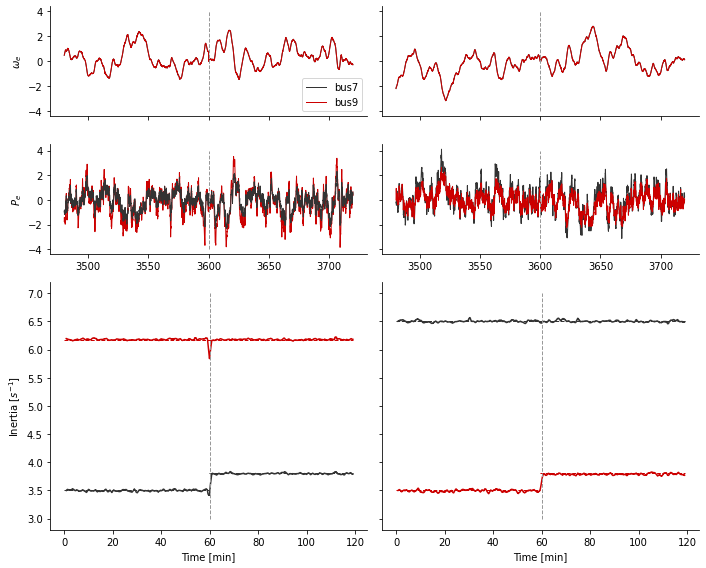

In [8]:
t0 = 3600
window = 120
idx = (t > t0 - window) & (t < t0 + window)
fig = plt.figure(figsize = (10,8))
gs = fig.add_gridspec(4, 2)
ax = [
    [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])],
    [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])],
    [fig.add_subplot(gs[2:,0]), fig.add_subplot(gs[2:,1])],
]

ax[0][0].plot(t[idx], data_normalized[0]['omegael_bus7'][idx], color=col[0], lw=1, label='bus7')
ax[0][0].plot(t[idx], data_normalized[0]['omegael_bus9'][idx], color=col[1], lw=1, label='bus9')
ax[1][0].plot(t[idx], data_normalized[0]['Pe_bus9'][idx], color=col[1], lw=1)
ax[1][0].plot(t[idx], data_normalized[0]['Pe_bus7'][idx], color=col[0], lw=1)

ax[2][0].plot(time[[0,time.size//2]] / 60, H_values[0] + np.zeros(2), '--', color=col[0], lw=1)
ax[2][0].plot(time[[time.size//2,-1]] / 60, H_values[1] + np.zeros(2), '--', color=col[0], lw=1)
ax[2][0].plot(time / 60, inertia[0][:,0], color=col[0])

ax[2][0].plot(time[[0,-1]] / 60, default_H[1] + np.zeros(2), '--', color=col[1], lw=1)
ax[2][0].plot(time / 60, inertia[0][:,1], color=col[1])

ax[0][1].plot(t[idx], data_normalized[1]['omegael_bus7'][idx], color=col[0], lw=1)
ax[0][1].plot(t[idx], data_normalized[1]['omegael_bus9'][idx], color=col[1], lw=1)
ax[1][1].plot(t[idx], data_normalized[1]['Pe_bus7'][idx], color=col[0], lw=1)
ax[1][1].plot(t[idx], data_normalized[1]['Pe_bus9'][idx], color=col[1], lw=1)

ax[2][1].plot(time[[0,time.size//2]] / 60, H_values[0] + np.zeros(2), '--', color=col[1], lw=1)
ax[2][1].plot(time[[time.size//2,-1]] / 60, H_values[1] + np.zeros(2), '--', color=col[1], lw=1)
ax[2][1].plot(time / 60, inertia[1][:,1], color=col[1])

ax[2][1].plot(time[[0,-1]] / 60, default_H[0] + np.zeros(2), '--', color=col[0], lw=1)
ax[2][1].plot(time / 60, inertia[1][:,0], color=col[0])

ax[2][0].set_xlabel('Time [min]')
ax[2][1].set_xlabel('Time [min]')

ax[0][0].legend(loc='lower right')

limits = [[-4,4], [-4,4], [3,7]]
for i in range(3):
    ax[i][0].get_shared_x_axes().join(ax[i][0], ax[i][1])
    ax[i][0].get_shared_y_axes().join(ax[i][0], ax[i][1])
    for a in ax[i]:
        if i == 2:
            a.plot(t0 / 60 + np.zeros(2), limits[i], '--', lw=1, color=[.6,.6,.6])
        else:
            a.plot(t0 + np.zeros(2), limits[i], '--', lw=1, color=[.6,.6,.6])
        for side in 'right', 'top':
            a.spines[side].set_visible(False)
    if i < 2:
        ax[0][i].set_xticklabels([])
    ax[i][1].set_yticklabels([])

ax[0][0].set_ylabel(r'$\omega_{e}$')
ax[1][0].set_ylabel(r'$P_{e}$')
ax[2][0].set_ylabel(r'Inertia [$s^{-1}$]')

fig.tight_layout()

fig.savefig('multi_area_prediction_step_H.pdf')